<a href="https://colab.research.google.com/github/markvasin/kaggle-quora-insincere-questions-classification/blob/master/Quora_Insincere_Questions_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Quora Insincere Questions Classification

https://www.kaggle.com/c/quora-insincere-questions-classification

###Packages

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string

%matplotlib inline

#Data Exploration

##Loading Data

In [44]:
# from google.colab import files
# uploaded = files.upload()

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
train_path = '/content/drive/My Drive/Colab Notebooks/Advanced Machine Learning/Data/train.csv'
test_path = '/content/drive/My Drive/Colab Notebooks/Advanced Machine Learning/Data/test.csv'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [46]:
print('Train shape : ', train_df.shape)
print('Test shape : ', test_df.shape)

Train shape :  (1306122, 3)
Test shape :  (375806, 2)


In [47]:
train_df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


##Target Distribution##

0 = Sincere Question

1 = Insincere Question

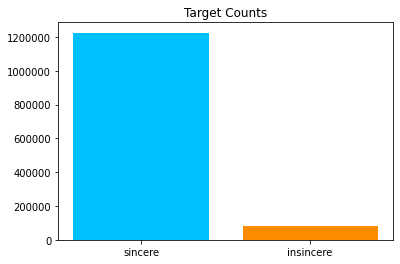

In [48]:
target_count = train_df['target'].value_counts()
targets = ['sincere', 'insincere']
plt.title('Target Counts')
plt.ticklabel_format(style='plain')
plt.bar(target_count.index, target_count.values, tick_label=targets, color = ['deepskyblue','darkorange'])
plt.show()

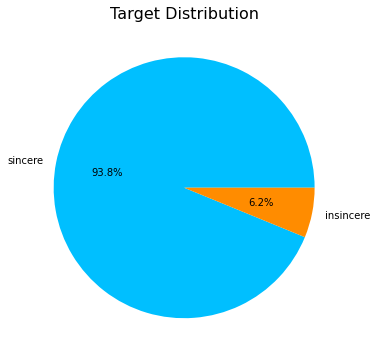

In [49]:
fig = plt.gcf()
fig.set_size_inches(12, 6)
plt.title('Target Distribution', fontsize=16)
plt.pie(target_count.values, labels=targets, autopct='%1.1f%%', colors=['deepskyblue','darkorange'])
plt.show()

##N Grams Visualisation

In [50]:
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import nltk
from wordcloud import WordCloud, STOPWORDS

from collections import Counter
from collections import defaultdict

nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
insincere_df = train_df[train_df['target']==1]
sincere_df = train_df[train_df['target']==0]

def get_ngram_df(texts, n=1):
  frequency = defaultdict(int)

  for text in texts:
    tokenized = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    n_grams = ngrams(tokenized, n)
    for words in n_grams:
      filter(None, words)
      words = ' '.join(words)
      frequency[words] += 1
      
  df = pd.DataFrame(sorted(frequency.items(), key=lambda x: x[1])[::-1])
  df.columns = ['word', 'wordcount']
  return df


def comparison_plot(sincer_df, insincer_df, col_1, col_2, space, n):
    fig, ax = plt.subplots(1, 2, figsize=(20,5))
    
    sns.barplot(x=col_2, y=col_1, data=sincer_df, ax=ax[0], color="deepskyblue")
    sns.barplot(x=col_2, y=col_1, data=insincer_df, ax=ax[1], color="darkorange")

    ax[0].set_xlabel('Word count', size=14)
    ax[0].set_ylabel('Words', size=14)
    ax[0].set_title(f'Top {n} words in sincere questions', size=18)

    ax[1].set_xlabel('Word count', size=14)
    ax[1].set_ylabel('Words', size=14)
    ax[1].set_title(f'Top {n} words in insincere questions', size=18)

    fig.subplots_adjust(wspace=space)
    
    plt.show()

####Unigram (Bag of Words)

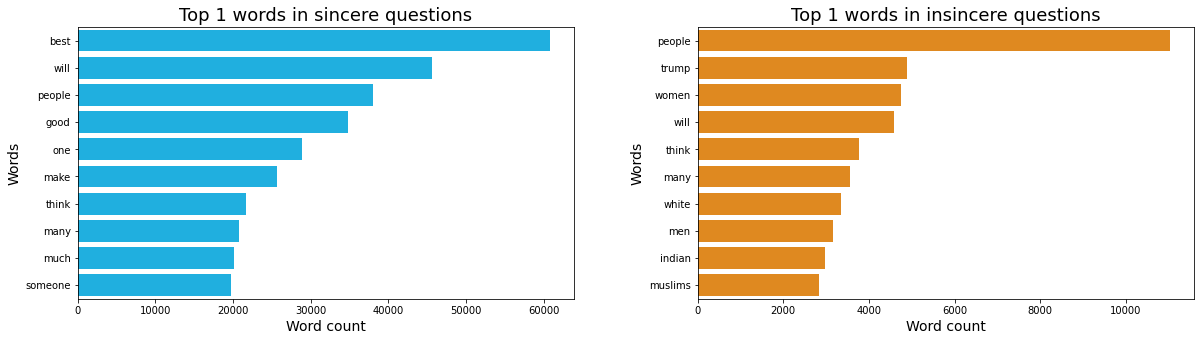

In [52]:
insincere_unigram_df = get_ngram_df(insincere_df['question_text'])
sincere_unigram_df = get_ngram_df(sincere_df['question_text'])

comparison_plot(sincere_unigram_df.head(10), insincere_unigram_df.head(10), 'word', 'wordcount', 0.25, 1)


####Bigram

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: generator 'ngrams' raised StopIteration
  # Remove the CWD from sys.path while we load stuff.


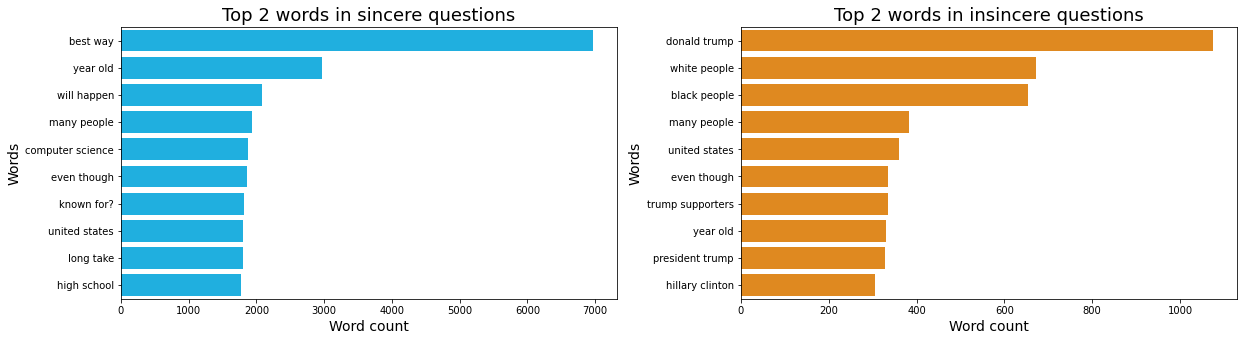

In [53]:
insincere_bigram_df = get_ngram_df(insincere_df['question_text'], 2)
sincere_bigram_df = get_ngram_df(sincere_df['question_text'], 2)

comparison_plot(sincere_bigram_df.head(10), insincere_bigram_df.head(10), 'word', 'wordcount', 0.25, 2)


####Trigram


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: generator 'ngrams' raised StopIteration
  # Remove the CWD from sys.path while we load stuff.


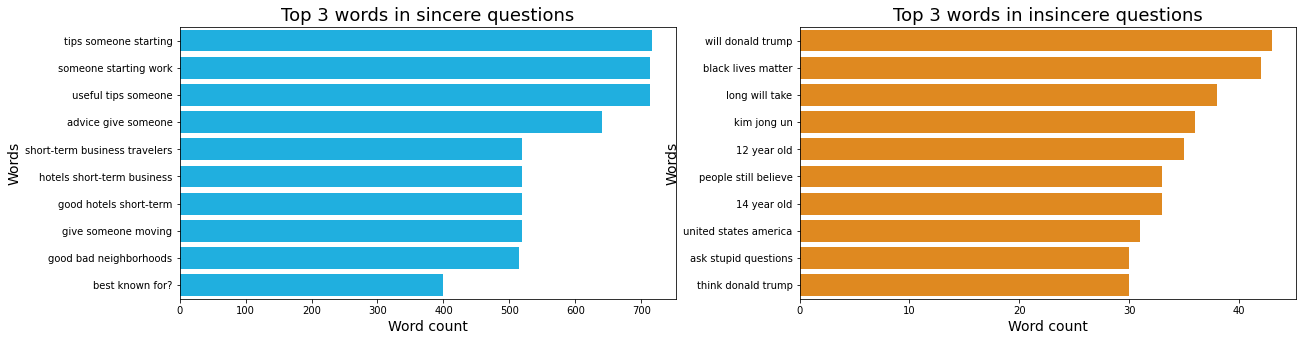

In [54]:
insincere_trigram_df = get_ngram_df(insincere_df['question_text'], 3)
sincere_trigram_df = get_ngram_df(sincere_df['question_text'], 3)

comparison_plot(sincere_trigram_df.head(10), insincere_trigram_df.head(10), 'word', 'wordcount', 0.25, 3)

##Word Cloud

####All Questions

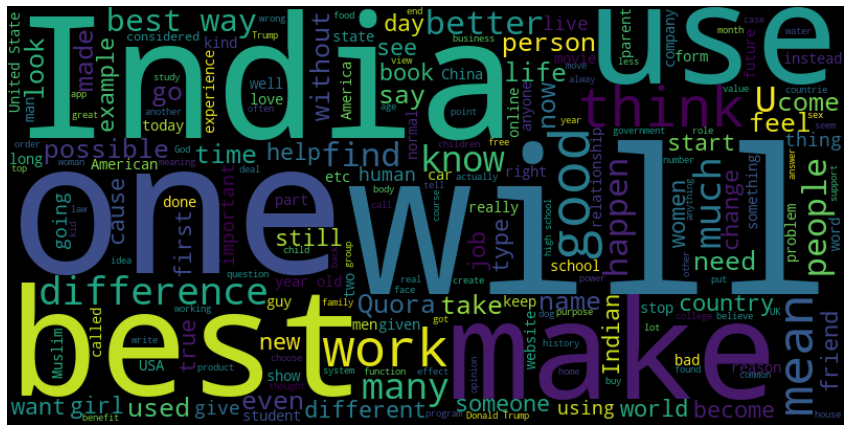

In [55]:
combined_text = train_df['question_text'].str.cat(sep=' ')
wordcloud = WordCloud(background_color='black', width=800, height=400, stopwords = set(STOPWORDS))
wordcloud.generate(combined_text)

# Display the generated image:
plt.figure(figsize=(15.0, 10.0))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

####Sincere Questions

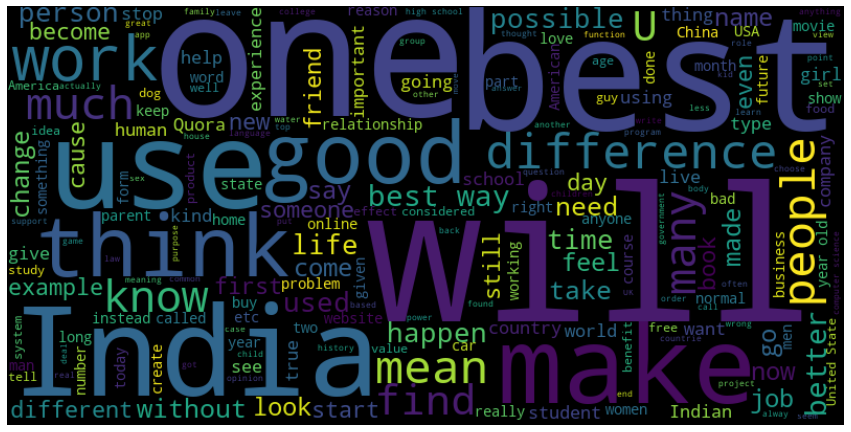

In [56]:
combined_text = sincere_df['question_text'].str.cat(sep=' ')
wordcloud = WordCloud(background_color='black', width=800, height=400, stopwords = set(STOPWORDS))
wordcloud.generate(combined_text)

# Display the generated image:
plt.figure(figsize=(15.0, 10.0))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

####Insincere Questions

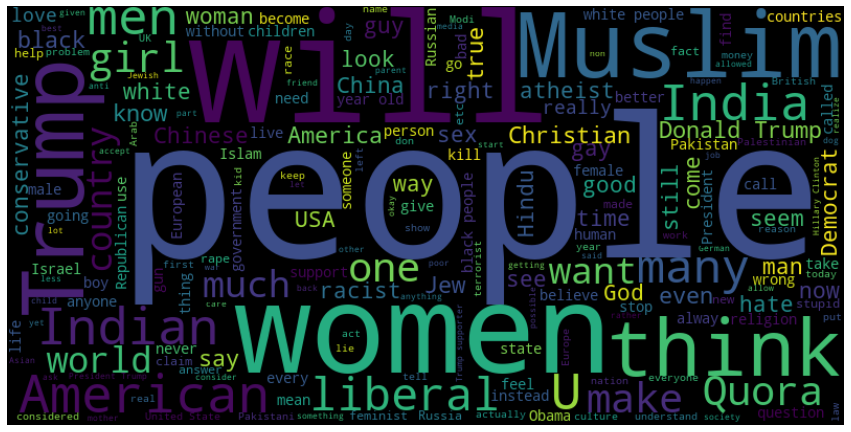

In [57]:
combined_text = insincere_df['question_text'].str.cat(sep=' ')
wordcloud = WordCloud(background_color='black', width=800, height=400, stopwords = set(STOPWORDS))
wordcloud.generate(combined_text)

# Display the generated image:
plt.figure(figsize=(15.0, 10.0))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

##Meta Features Exploration##
1. Number of words in the text
2. Number of unique words in the text
3. Number of characters in the text
4. Number of stopwords
5. Number of punctuations
6. Number of upper case words
7. Average length of the words

In [0]:
## Number of words in the text ##
train_df["num_words"] = train_df["question_text"].apply(lambda x: len(str(x).split()))

## Number of unique words in the text ##
train_df["num_unique_words"] = train_df["question_text"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the text ##
train_df["num_chars"] = train_df["question_text"].apply(lambda x: len(str(x)))

## Number of stopwords in the text ##
train_df["num_stopwords"] = train_df["question_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

## Number of punctuations in the text ##
train_df["num_punctuations"] =train_df['question_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Number of upper case words in the text ##
train_df["num_words_upper"] = train_df["question_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Average length of the words in the text ##
train_df["mean_word_len"] = train_df["question_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

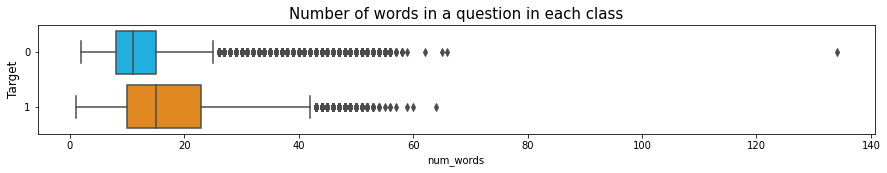

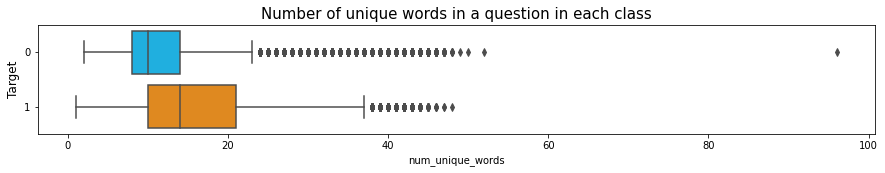

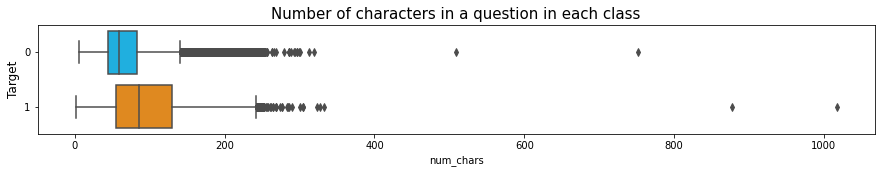

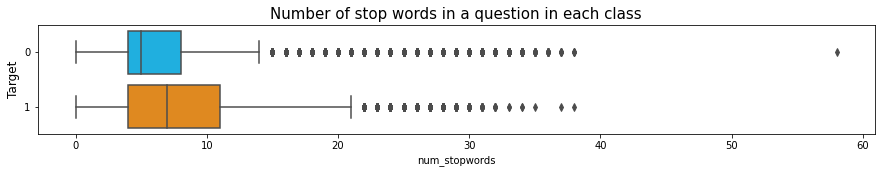

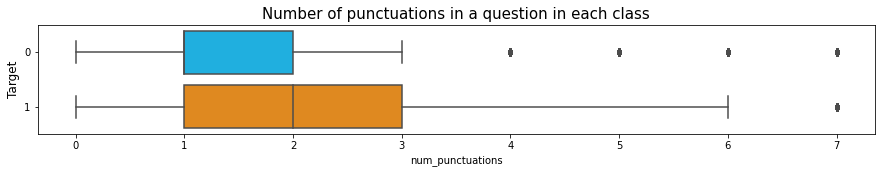

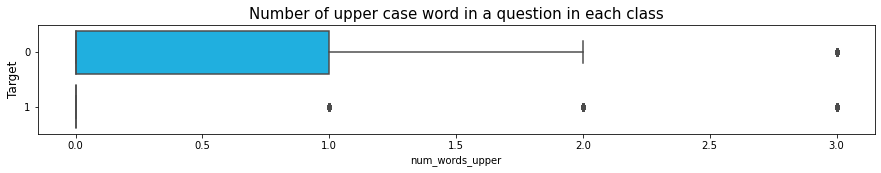

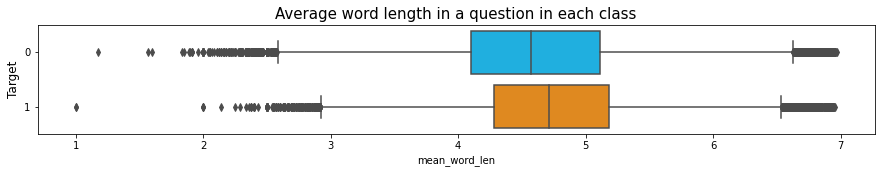

In [85]:
## Number of words in the text ##
fig, ax = plt.subplots(figsize=(15,2))
ax = sns.boxplot(x='num_words', y='target', data=train_df, orient='h', palette=['deepskyblue', 'darkorange'])
ax.set_ylabel('Target', fontsize=12)
ax.set_title("Number of words in a question in each class", fontsize=15)

## Number of unique words in the text ##
fig, ax = plt.subplots(figsize=(15,2))
ax = sns.boxplot(x='num_unique_words', y='target', data=train_df, orient='h', palette=['deepskyblue', 'darkorange'])
ax.set_ylabel('Target', fontsize=12)
ax.set_title("Number of unique words in a question in each class", fontsize=15)

## Number of characters in the text ##
fig, ax = plt.subplots(figsize=(15,2))
ax = sns.boxplot(x='num_chars', y='target', data=train_df, orient='h', palette=['deepskyblue', 'darkorange'])
ax.set_ylabel('Target', fontsize=12)
ax.set_title("Number of characters in a question in each class", fontsize=15)

## Number of stopwords in the text ##
fig, ax = plt.subplots(figsize=(15,2))
ax = sns.boxplot(x='num_stopwords', y='target', data=train_df, orient='h', palette=['deepskyblue', 'darkorange'])
ax.set_ylabel('Target', fontsize=12)
ax.set_title("Number of stop words in a question in each class", fontsize=15)

## Number of punctuations in the text ##
fig, ax = plt.subplots(figsize=(15,2))
ax = sns.boxplot(x='num_punctuations', y='target', data=train_df[train_df['num_punctuations']<train_df['num_punctuations'].quantile(.99)], orient='h', palette=['deepskyblue', 'darkorange'])
ax.set_ylabel('Target', fontsize=12)
ax.set_title("Number of punctuations in a question in each class", fontsize=15)

## Number of upper case words in the text ##
fig, ax = plt.subplots(figsize=(15,2))
ax = sns.boxplot(x='num_words_upper', y='target', data=train_df[train_df['num_words_upper']<train_df['num_words_upper'].quantile(.99)], orient='h', palette=['deepskyblue', 'darkorange'])
ax.set_ylabel('Target', fontsize=12)
ax.set_title("Number of upper case word in a question in each class", fontsize=15)

## Average length of the words in the text ##
fig, ax = plt.subplots(figsize=(15,2))
ax = sns.boxplot(x='mean_word_len', y='target', data=train_df[train_df['mean_word_len']<train_df['mean_word_len'].quantile(.99)], orient='h', palette=['deepskyblue', 'darkorange'])
ax.set_ylabel('Target', fontsize=12)
ax.set_title("Average word length in a question in each class", fontsize=15)

plt.show()